In [ ]:
# # !pip install spotipy
# !pip install lightgbm
# !pip install shap
# !pip install player

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/247.3 kB ? eta -:--:--
   ----------------------- ---------------- 143.4/247.3 kB 4.3 MB/s eta 0:00:01
   ---------------------------------------  245.8/247.3 kB 3.0 MB/s eta 0:00:01
   ---------------------------------------- 247.3/247.3 kB 2.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/43.2 kB ? eta -:--:--
   ---------------------------------------- 43.2/43.2 kB 2.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/115.4 kB ? eta -:--:--
   ---------------------------------------  112.6/115.4 kB 2.2 MB/s eta 0:00:01
   ---------------------------------------- 115.4/115.4 kB 1.7 MB/s eta 0:00:00
  Created wheel for player: filename=player-0.6.1-py3-none-any.whl size=23060 sha256=f521ac746dfd00d8358f842fbbb6d5ef6fea2e020ef4236bfeda71d008c3d3f2
  Stored in directory: c:\users\jonny\appdata\local\pip\ca

# Initialization

In [ ]:
import os
import time
from tqdm import tqdm
import requests
import spotipy
import pandas as pd
import numpy as np
import shap
from scipy.stats import randint, uniform, loguniform
from scipy.stats import mannwhitneyu, f_oneway, shapiro
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, classification_report, precision_recall_curve, confusion_matrix, roc_curve
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from spotipy.oauth2 import SpotifyOAuth
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import warnings

In [2]:
warnings.filterwarnings("ignore", category=UserWarning)

# Environment Setup

In [ ]:
# Load environment variables from .env file
load_dotenv()

redirect_uri = os.getenv('SPOTIPY_REDIRECT_URI')
client_id = os.getenv('SPOTIPY_CLIENT_ID')
client_secret = os.getenv('SPOTIPY_CLIENT_SECRET')

# Authenticate with SpotifyOAuth
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(
    client_id=client_id,
    client_secret=client_secret,
    redirect_uri=redirect_uri,
    scope="user-library-read user-read-private"
))

# Helper Functions

In [ ]:

def get_track_id(track_name, artist_name):
    """Fetch the track ID using the Spotify API search."""
    result = sp.search(q=f"track:{track_name} artist:{artist_name}", type="track", limit=1)
    if result['tracks']['items']:
        return result['tracks']['items'][0]['id']
    else:
        return None

def normalize(text):
    """Normalize a string by converting it to lowercase and stripping extra spaces."""
    return text.lower().strip() if isinstance(text, str) else text

def create_features(df):
    """Feature engineering: create interaction features."""
    df['energy_loudness'] = df['energy'] * df['loudness']
    df['speechiness_loudness'] = df['speechiness'] * df['loudness']
    df['hit_probability'] = df['chorus_hit'] / (df['sections'] + 1)  # Avoid division by zero
    return df

def find_best_threshold(model, X_val, y_val):
    """Find the decision threshold that maximizes the F1-score."""
    probs = model.predict_proba(X_val)[:, 1]
    thresholds = np.linspace(0.3, 0.7, 50)
    best_f1, best_threshold = 0, 0.5
    for t in thresholds:
        preds = (probs >= t).astype(int)
        f1 = f1_score(y_val, preds)
        if f1 > best_f1:
            best_f1, best_threshold = f1, t
    return best_threshold, best_f1

# Data Extraction

In [ ]:
df = pd.read_csv('data/spotify_full_list_20102023.csv', header=0)

,Unnamed: 0,Artist and Title,Artist,Streams,Daily,year,main_genre,genres,first_genre,second_genre,third_genre
0,0,J. Cole - No Role Modelz,J. Cole,2300753974,987553,2014.0,Hip-Hop/Rap,"['conscious hip hop', 'hip hop', 'north caroli...",conscious hip hop,hip hop,north carolina hip hop
1,1,Sam Smith - Stay With Me,Sam Smith,2135129240,875392,2014.0,Pop,"['pop', 'uk pop']",pop,uk pop,Unknown
2,2,Mark Ronson - Uptown Funk,Mark Ronson,2039781091,675268,2014.0,Pop,['pop soul'],pop soul,Unknown,Unknown
3,3,Sam Smith - I'm Not The Only One,Sam Smith,1926711475,791299,2014.0,Pop,"['pop', 'uk pop']",pop,uk pop,Unknown
4,4,Maroon 5 - Sugar,Maroon 5,1877824112,552959,2014.0,Pop,['pop'],pop,Unknown,Unknown
...,...,...,...,...,...,...,...,...,...,...,...
10436,21611,iann dior - molly,iann dior,138112487,21049,2019.0,Hip-Hop/Rap,['melodic rap'],melodic rap,Unknown,Unknown
10437,21612,Roddy Ricch - Tip Toe,Roddy Ricch,137996968,10699,2019.0,Hip-Hop/Rap,"['melodic rap', 'rap', 'trap']",melodic rap,rap,trap
10438,21613,Sigrid - Strangers,Sigrid,137925577,15840,2019.0,Pop,"['electropop', 'norwegian pop']",electropop,norwegian pop,Unknown
10439,21614,GAMPER & DADONI - Gimme! Gimme! Gimme!,GAMPER & DADONI,137471196,60612,2019.0,Electronic/Dance,"['german dance', 'pop dance', 'tropical house']",german dance,pop dance,tropical house


In [ ]:
# Create a track name column by splitting "Artist and Title"
df['track_name'] = df['Artist and Title'].str.split('-', n=1).str[1].fillna(df['Artist and Title'])

KeyError: 'track_name'

In [ ]:
# Cache to avoid repeated API calls
cache = {}
def get_track_id_batch(names_artists):
    """
    Fetch track IDs for a list of (track_name, artist) tuples.
    """
    track_ids = []
    for name, artist in names_artists:
        key = (name, artist)
        if key in cache:
            track_ids.append(cache[key])
        else:
            try:
                track_id = get_track_id(name, artist)
                cache[key] = track_id
                track_ids.append(track_id)
            except Exception as e:
                track_ids.append(None)
            time.sleep(0.1)  # Pause to respect API rate limits
    return track_ids

# Split the dataframe into batches and fetch track IDs
batch_size = 50
batches = [df.iloc[i:i + batch_size] for i in range(0, len(df), batch_size)]
for batch in tqdm(batches):
    names_artists = list(zip(batch['track_name'], batch['Artist']))
    batch['track_id'] = get_track_id_batch(names_artists)
df_final = pd.concat(batches, ignore_index=True)

# Save the dataset with track IDs
os.makedirs("data", exist_ok=True)
df_final.to_pickle("data/tracks_with_ids.pkl")
df_final.to_csv('data/tracks_with_ids.csv', index=False)

  0%|          | 0/209 [00:00<?, ?it/s]C:\Users\Jonny\AppData\Local\Temp\ipykernel_36692\3487910097.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['track_id'] = get_track_id_batch(names_artists)
  0%|          | 1/209 [00:10<36:59, 10.67s/it]C:\Users\Jonny\AppData\Local\Temp\ipykernel_36692\3487910097.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch['track_id'] = get_track_id_batch(names_artists)
  1%|          | 2/209 [00:21<36:16, 10.52s/it]C:\Users\Jonny\AppData\Local\Temp\ipykernel

In [ ]:
save_path_pickle = "data/tracks_with_ids.pkl"
df_final.to_pickle(save_path_pickle)
df_final.to_csv('data/tracks_with_ids.csv')

# Data processing

In [ ]:
# Load enriched audio features dataset
df_enriched2 = pd.read_csv('data/audio_features.csv', header=0)
df_enriched2.rename({'performer': 'artist', 'song': 'track'}, axis='columns', inplace=True)
df_enriched2.drop(['song_id','spotify_track_preview_url', 'spotify_track_explicit', 'spotify_track_album'], axis=1, inplace=True)
df_enriched2.dropna(thresh=7, inplace=True)
df_enriched2

,artist,track,spotify_genre,spotify_track_id,spotify_track_duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,spotify_track_popularity
2,Andy Williams,......And Roses And Roses,"['adult standards', 'brill building pop', 'eas...",3tvqPPpXyIgKrm4PR9HCf0,166106.0,0.154,0.185,5.0,-14.063,1.0,0.0315,0.91100,0.000267,0.1120,0.150,83.969,4.0,38.0
3,Sandy Nelson,...And Then There Were Drums,"['rock-and-roll', 'space age pop', 'surf music']",1fHHq3qHU8wpRKHzhojZ4a,172066.0,0.588,0.672,11.0,-17.278,0.0,0.0361,0.00256,0.745000,0.1450,0.801,121.962,4.0,11.0
4,Britney Spears,...Baby One More Time,"['dance pop', 'pop', 'post-teen pop']",3MjUtNVVq3C8Fn0MP3zhXa,211066.0,0.759,0.699,0.0,-5.745,0.0,0.0307,0.20200,0.000131,0.4430,0.907,92.960,4.0,77.0
5,Taylor Swift,...Ready For It?,"['pop', 'post-teen pop']",2yLa0QULdQr0qAIvVwN6B5,208186.0,0.613,0.764,2.0,-6.509,1.0,0.1360,0.05270,0.000000,0.1970,0.417,160.015,4.0,73.0
7,Paul Davis,'65 Love Affair,"['album rock', 'bubblegum pop', 'country rock'...",5nBp8F6tekSrnFg8G2Pvug,219813.0,0.647,0.686,2.0,-4.247,0.0,0.0274,0.43200,0.000006,0.1330,0.952,155.697,4.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29495,The Five Americans,Zip Code,"['bubblegum pop', 'classic garage rock', 'frea...",7hTW791CEdFSlw2wouCVYP,175040.0,0.393,0.594,9.0,-5.986,1.0,0.0267,0.03940,0.000000,0.0479,0.927,139.535,4.0,5.0
29497,Bad Wolves,Zombie,"['alternative metal', 'metal', 'post-grunge']",1vNoA9F5ASnlBISFekDmg3,254805.0,0.448,0.826,2.0,-3.244,0.0,0.0319,0.00756,0.000000,0.1170,0.190,77.093,4.0,74.0
29499,Future,Zoom,"['atl hip hop', 'hip hop', 'pop rap', 'rap', '...",2IG6Te7JyvrtqhFeOF7le4,278429.0,0.852,0.438,9.0,-7.673,1.0,0.4260,0.01450,0.000000,0.2630,0.627,150.945,4.0,51.0
29501,Herb Alpert & The Tijuana Brass,Zorba The Greek,"['adult standards', 'easy listening', 'lounge']",3WLEVNohakzZmMpN5W7mHK,264853.0,0.531,0.642,5.0,-12.702,1.0,0.3230,0.15400,0.279000,0.0584,0.192,82.107,4.0,35.0


In [ ]:
# Load the dataset with track IDs
df_enriched = pd.read_csv('data/tracks_with_ids.csv', header=0)
df_enriched.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1, inplace=True)
df_enriched

,Artist and Title,Artist,Streams,Daily,year,main_genre,genres,first_genre,second_genre,third_genre,track_name,track_id
0,J. Cole - No Role Modelz,J. Cole,2300753974,987553,2014.0,Hip-Hop/Rap,"['conscious hip hop', 'hip hop', 'north caroli...",conscious hip hop,hip hop,north carolina hip hop,No Role Modelz,NaN
1,Sam Smith - Stay With Me,Sam Smith,2135129240,875392,2014.0,Pop,"['pop', 'uk pop']",pop,uk pop,Unknown,Stay With Me,NaN
2,Mark Ronson - Uptown Funk,Mark Ronson,2039781091,675268,2014.0,Pop,['pop soul'],pop soul,Unknown,Unknown,Uptown Funk,NaN
3,Sam Smith - I'm Not The Only One,Sam Smith,1926711475,791299,2014.0,Pop,"['pop', 'uk pop']",pop,uk pop,Unknown,I'm Not The Only One,1G5H6Dh8AmuUZY7abHcYMH
4,Maroon 5 - Sugar,Maroon 5,1877824112,552959,2014.0,Pop,['pop'],pop,Unknown,Unknown,Sugar,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
10436,iann dior - molly,iann dior,138112487,21049,2019.0,Hip-Hop/Rap,['melodic rap'],melodic rap,Unknown,Unknown,molly,NaN
10437,Roddy Ricch - Tip Toe,Roddy Ricch,137996968,10699,2019.0,Hip-Hop/Rap,"['melodic rap', 'rap', 'trap']",melodic rap,rap,trap,Tip Toe,6NbXfStqkrYH8z1QMsfJr0
10438,Sigrid - Strangers,Sigrid,137925577,15840,2019.0,Pop,"['electropop', 'norwegian pop']",electropop,norwegian pop,Unknown,Strangers,NaN
10439,GAMPER & DADONI - Gimme! Gimme! Gimme!,GAMPER & DADONI,137471196,60612,2019.0,Electronic/Dance,"['german dance', 'pop dance', 'tropical house']",german dance,pop dance,tropical house,Gimme! Gimme! Gimme!,NaN


In [ ]:
# Read additional feature CSVs from the "features" folder
folder = "features"
dfs = []
for filename in os.listdir(folder):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder, filename)
        temp_df = pd.read_csv(file_path)
        temp_df.columns = [col.lower().strip() for col in temp_df.columns]
        if 'artist' in temp_df.columns and 'track' in temp_df.columns:
            temp_df['artist_norm'] = temp_df['artist'].apply(normalize)
            temp_df['track_norm'] = temp_df['track'].apply(normalize)
            dfs.append(temp_df)
if len(dfs) > 0:
    df_features = pd.concat(dfs, ignore_index=True)
df_features.rename({'artist': 'Artist'}, axis='columns', inplace=True)

In [ ]:
# Normalize artist and track names in all datasets
df_features['artist_norm'] = df_features['Artist'].apply(normalize)
df_features['track_norm'] = df_features['track'].apply(normalize)
df_enriched['artist_norm'] = df_enriched['Artist'].apply(normalize)
df_enriched['track_norm'] = df_enriched['track_name'].apply(normalize)
df_enriched2['artist_norm'] = df_enriched2['artist'].apply(normalize)
df_enriched2['track_norm'] = df_enriched2['track'].apply(normalize)

print("Original records in df_features:", len(df_features))
print("Original records in df_enriched:", len(df_enriched))
print("Original records in df_enriched2:", len(df_enriched2))

# Remove duplicates based on unique track identifiers
df_features.drop_duplicates(subset=['Artist', 'track'], inplace=True)
df_enriched.drop_duplicates(subset=['Artist', 'track_name'], inplace=True)
df_enriched2.drop_duplicates(subset=['artist', 'track'], inplace=True)

print("After removing duplicates, df_features:", len(df_features))
print("After removing duplicates, df_enriched:", len(df_enriched))
print("After removing duplicates, df_enriched2:", len(df_enriched2))

# Create a set of tuples (artist_norm, track_norm) for TOP100 tracks
top100_set = set(zip(df_enriched['artist_norm'], df_enriched['track_norm']))
top100_set2 = set(zip(df_enriched2['artist_norm'], df_enriched2['track_norm']))
top100_combined = top100_set.union(top100_set2)

# Create a new 'in_top100' column in df_features (1 if track is in TOP100, else 0)
df_features['in_top100'] = df_features.apply(
    lambda row: 1 if (row['artist_norm'], row['track_norm']) in top100_combined else 0, axis=1
)
print("Number of TOP songs in df_features:", len(df_features.loc[df_features['in_top100'] == 1]))

# Remove auxiliary normalization columns if desired
df_features.drop(columns=['target', 'artist_norm', 'track_norm'], inplace=True)
print("Merge completed! The final dataset has the 'in_top100' column.")

Original records df_features: 40003
Original records df_enriched: 10238
Original records df_enriched2: 24224
After removing duplicates df_features: 40003
After removing duplicates df_enriched: 10238
After removing duplicates df_enriched2: 24224
19436
Merge completed! The final dataset has the 'in_top100' column.


# Exploratory Data Analysis

In [ ]:
# Define features for analysis
features = [
    'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
    'duration_ms', 'time_signature', 'chorus_hit', 'sections'
]

# Separate data into TOP and non-TOP groups
df_top = df_features[df_features['in_top100'] == 1]
df_non_top = df_features[df_features['in_top100'] == 0]

# Plot Histograms for each feature (separate for TOP and non-TOP)
for feature in features:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)
    sns.histplot(data=df_top, x=feature, bins=30, kde=True, ax=axes[0], color='blue')
    axes[0].set_title(f"{feature} - TOP")
    axes[0].set_xlabel(feature)
    
    sns.histplot(data=df_non_top, x=feature, bins=30, kde=True, ax=axes[1], color='green')
    axes[1].set_title(f"{feature} - non-TOP")
    axes[1].set_xlabel(feature)
    
    plt.tight_layout()
    plt.show()

# Plot Boxplots for each feature by group
for feature in features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='in_top100', y=feature, data=df_features, hue='in_top100', palette=["green", "blue"])
    plt.title(f"Boxplot of {feature} by Group")
    plt.xticks([0, 1], ["non-TOP", "TOP"])
    plt.tight_layout()
    plt.show()

In [ ]:
# Descriptive statistics by group
stats_by_group = df_features.groupby('in_top100')[features].describe().transpose()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
print("Descriptive Statistics by Group:")
print(stats_by_group)
# Optionally, save the stats to CSV:
# stats_by_group.to_csv("descriptive_statistics_by_group_full.csv", index=True)
pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')
pd.reset_option('display.width')

In [ ]:
# Mann-Whitney U Test for each feature
p_values = {}
for feature in features:
    top_data = df_top[feature].dropna()
    non_top_data = df_non_top[feature].dropna()
    stat, p = mannwhitneyu(top_data, non_top_data, alternative='two-sided')
    p_values[feature] = p
p_values_df = pd.DataFrame(list(p_values.items()), columns=['Feature', 'p_value'])
print("Mann-Whitney U test p-values:")
print(p_values_df)

In [ ]:
# Correlation Matrix Plot
plt.figure(figsize=(12, 6))
corr_matrix = df_features[features + ['in_top100']].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

In [ ]:
# ANOVA analysis for each feature
anova_results = {}
for feature in features:
    f_stat, p_val = f_oneway(df_top[feature], df_non_top[feature])
    anova_results[feature] = p_val
anova_results_df = pd.DataFrame(list(anova_results.items()), columns=['Feature', 'p-value'])
print("ANOVA Test p-values:")
print(anova_results_df)

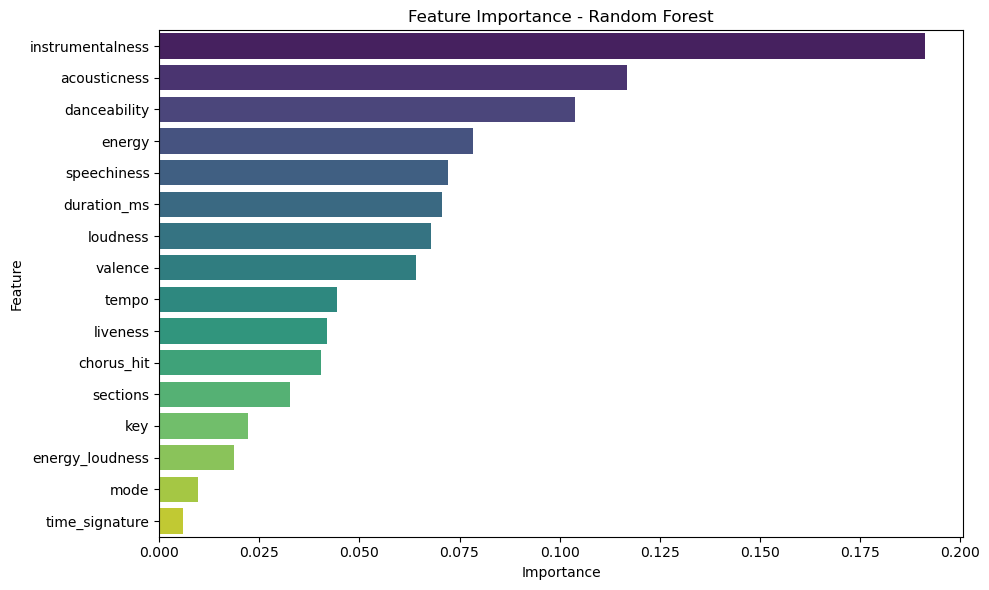

In [ ]:
# Shapiro-Wilk normality test for each feature
normality_results = {}
for feature in features:
    stat, p_val = shapiro(df_features[feature])
    normality_results[feature] = p_val
normality_results_df = pd.DataFrame(list(normality_results.items()), columns=['Feature', 'p-value'])
print("Shapiro-Wilk test p-values:")
print(normality_results_df)

# Calculate VIF for each feature (after adding constant)
X_vif = df_features[features]
X_vif = add_constant(X_vif)
vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print("Variance Inflation Factors (VIF):")
print(vif_data)

# Model Testing with Additional Hyperparameter Tuning

In [ ]:
# Create additional features
df_features = create_features(df_features)

# Split the data into features and target (dropping identifier columns)
X = df_features.drop(columns=['track', 'Artist', 'uri', 'in_top100'])
y = df_features['in_top100']

# Split into training and testing sets for tuning
X_train_tuning, X_test_tuning, y_train_tuning, y_test_tuning = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Additional Hyperparameter Tuning for RandomForest and XGBoost
param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [10, 15], 'min_samples_split': [2, 5]}
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.05],
    'colsample_bytree': [0.8, 1.0],
    'subsample': [0.8, 1.0]
}

rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, scoring='roc_auc', cv=3)
xgb_grid = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), param_grid_xgb, scoring='roc_auc', cv=3)

rf_grid.fit(X_train_tuning, y_train_tuning)
xgb_grid.fit(X_train_tuning, y_train_tuning)

best_rf = rf_grid.best_estimator_
best_xgb = xgb_grid.best_estimator_

best_threshold_rf, best_f1_rf = find_best_threshold(best_rf, X_test_tuning, y_test_tuning)
best_threshold_xgb, best_f1_xgb = find_best_threshold(best_xgb, X_test_tuning, y_test_tuning)

rf_preds = (best_rf.predict_proba(X_test_tuning)[:, 1] >= best_threshold_rf).astype(int)
xgb_preds = (best_xgb.predict_proba(X_test_tuning)[:, 1] >= best_threshold_xgb).astype(int)

print(f"Random Forest - Best Threshold: {best_threshold_rf}, F1-score: {best_f1_rf}")
print(confusion_matrix(y_test_tuning, rf_preds))
print(classification_report(y_test_tuning, rf_preds))

print(f"XGBoost - Best Threshold: {best_threshold_xgb}, F1-score: {best_f1_xgb}")
print(confusion_matrix(y_test_tuning, xgb_preds))
print(classification_report(y_test_tuning, xgb_preds))

Random Forest - Best Threshold: 0.43061224489795913, F1-score: 0.7898665460303099
[[2651 1458]
 [ 400 3492]]
              precision    recall  f1-score   support

           0       0.87      0.65      0.74      4109
           1       0.71      0.90      0.79      3892

    accuracy                           0.77      8001
   macro avg       0.79      0.77      0.77      8001
weighted avg       0.79      0.77      0.76      8001

XGBoost - Best Threshold: 0.4551020408163265, F1-score: 0.7926575848533826
[[2772 1337]
 [ 459 3433]]
              precision    recall  f1-score   support

           0       0.86      0.67      0.76      4109
           1       0.72      0.88      0.79      3892

    accuracy                           0.78      8001
   macro avg       0.79      0.78      0.77      8001
weighted avg       0.79      0.78      0.77      8001



In [ ]:
# Predictions on the training set using fixed thresholds
y_pred_rf_train = (best_rf.predict_proba(X_train_tuning)[:, 1] >= 0.3).astype(int)
y_pred_xgb_train = (best_xgb.predict_proba(X_train_tuning)[:, 1] >= 0.38).astype(int)

print("Random Forest - Training Set")
print(classification_report(y_train_tuning, y_pred_rf_train))

print("\nRandom Forest - Test Set")
print(classification_report(y_test_tuning, (best_rf.predict_proba(X_test_tuning)[:, 1] >= 0.3).astype(int)))

print("\nXGBoost - Training Set")
print(classification_report(y_train_tuning, y_pred_xgb_train))

print("\nXGBoost - Test Set")
print(classification_report(y_test_tuning, (best_xgb.predict_proba(X_test_tuning)[:, 1] >= 0.38).astype(int)))

Random Forest - Treino
              precision    recall  f1-score   support

           0       1.00      0.65      0.79     16458
           1       0.73      1.00      0.85     15544

    accuracy                           0.82     32002
   macro avg       0.87      0.83      0.82     32002
weighted avg       0.87      0.82      0.82     32002


Random Forest - Teste
              precision    recall  f1-score   support

           0       0.92      0.54      0.68      4109
           1       0.66      0.95      0.78      3892

    accuracy                           0.74      8001
   macro avg       0.79      0.74      0.73      8001
weighted avg       0.80      0.74      0.73      8001


XGBoost - Treino
              precision    recall  f1-score   support

           0       0.91      0.64      0.75     16458
           1       0.71      0.93      0.81     15544

    accuracy                           0.78     32002
   macro avg       0.81      0.79      0.78     32002
weighted a

In [ ]:
cv_scores_rf = cross_val_score(rf_grid, X_train_tuning, y_train_tuning, cv=5, scoring='f1')
cv_scores_xgb = cross_val_score(xgb_grid, X_train_tuning, y_train_tuning, cv=5, scoring='f1')

print(f"Random Forest - Cross-Validation F1-score: {cv_scores_rf.mean():.3f} ± {cv_scores_rf.std():.3f}")
print(f"XGBoost - Cross-Validation F1-score: {cv_scores_xgb.mean():.3f} ± {cv_scores_xgb.std():.3f}")


Random Forest - Cross-Validation F1-score: 0.779 ± 0.003
XGBoost - Cross-Validation F1-score: 0.780 ± 0.005


# Final Report

In [ ]:
with open("final_report.txt", "w", encoding="utf-8") as f:
    f.write("Music Feature Analysis for TOP Songs\n")
    f.write("====================================\n\n")
    f.write("1. Descriptive Statistics by Group:\n")
    f.write(stats_by_group.to_string())
    f.write("\n\n2. Mann-Whitney U Test p-values:\n")
    f.write(p_values_df.to_string(index=False))
    f.write("\n\n3. ANOVA Test p-values:\n")
    f.write(anova_results_df.to_string(index=False))
    f.write("\n\n4. Observations:\n")
    f.write("   - The musical features, although informative, do not fully explain song popularity due to external factors (e.g., marketing, cultural trends).\n")
    f.write("   - Certain features (see feature importance plot) are more influential in distinguishing TOP songs, yet inherent variability remains.\n")
    f.write("   - Consider incorporating contextual data to further enhance the model.\n")
    
print("Final report and all plots have been saved.")

Final report and all plots have been saved.
